# Construction PPE Object Detection: 
### <b><u>Hybrid Model Training</b></u>
##### AAI-501 Group 4: Fatimat Atanda, Victor Hugo Germano, Darin Verduzco
GitHub: https://github.com/victorhg/aai-501-final-project

# Dataset setup:
Download hybrid "datasets" folder
<br>into the current <b><u>"hybrid_model_train"</b></u> directory:
<br><br><b>Manually-annotated datasets: For images annotated manually</b>
<br>./datasets/manually_annotated/raw_images (178 images)
<br>./datasets/manually_annotated/raw_labels (178 labels)
<b><br><br>Auto-annotated datasets: For images annotated with pre-trained model</b>
<br>- Raw Images Datasets: Contains images not annotated
<br>./datasets/raw_images (2746 images)
<br>(note: file names larger than 99 characters may not be read, update manually)

### Import Modules and Libraries

In [12]:
import os # File 
import cv2 # Opencv for images
import yaml
import glob
import torch
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from ultralytics import YOLO # For obeject detection
import albumentations as A # For image augmentation
from albumentations.pytorch import ToTensorV2 # For image formating
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

### Create directories

In [13]:
# Create direcories to organize images and cleanup for to avoid duplicate images 
dataset_base_dir = "datasets/"
# Source directory containing all raw manually annotated images
manual_source_images_dir = os.path.join(dataset_base_dir, "manually_annotated/raw_images")
manual_source_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/raw_labels")
# Source directory containing all raw unannotated images 
raw_images_dir = os.path.join(dataset_base_dir, "raw_images")

# Create auto-annotated directories
auto_annotated_images_dir = os.path.join(dataset_base_dir, "auto_annotated/images")
auto_annotated_labels_dir = os.path.join(dataset_base_dir, "auto_annotated/labels")
# Create manually annotated directories
manual_train_images_dir = os.path.join(dataset_base_dir, "manually_annotated/images/train")
manual_train_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/labels/train")
manual_val_images_dir = os.path.join(dataset_base_dir, "manually_annotated/images/val")
manual_val_labels_dir = os.path.join(dataset_base_dir, "manually_annotated/labels/val")

### Reset directories

In [14]:
def reset_directories(directories):
    """
    Check if directories exist. Delete and recreate them if they do.
    Ensures the directories are clean before use.

    Parameters:
        directories (list): List of directories to reset.
    """
    for path in directories:
        if os.path.exists(path):
            # delete the directory and all its contents
            try:
                shutil.rmtree(path)
                print(f"Deleted existing directory: {path}")
            except Exception as e:
                print(f"Failed to delete {path}. Reason: {e}")
        
        # Recreate the directory
        try:
            os.makedirs(path, exist_ok=True)
            print(f"Recreated directory: {path}")
        except Exception as e:
            print(f"Failed to create directory {path}. Reason: {e}")

# Define directories to reset
directories_to_reset = [
    auto_annotated_images_dir,
    auto_annotated_labels_dir,


    # manually annotated directories
    manual_train_images_dir,
    manual_train_labels_dir,
    manual_val_images_dir,
    manual_val_labels_dir 
]

# Reset directories
reset_directories(directories_to_reset)
print("Directories reset and ready for use.")

# Set random seed for reproducibility
random.seed(42)

Deleted existing directory: datasets/auto_annotated/images
Recreated directory: datasets/auto_annotated/images
Deleted existing directory: datasets/auto_annotated/labels
Recreated directory: datasets/auto_annotated/labels
Deleted existing directory: datasets/manually_annotated/images/train
Recreated directory: datasets/manually_annotated/images/train
Deleted existing directory: datasets/manually_annotated/labels/train
Recreated directory: datasets/manually_annotated/labels/train
Deleted existing directory: datasets/manually_annotated/images/val
Recreated directory: datasets/manually_annotated/images/val
Deleted existing directory: datasets/manually_annotated/labels/val
Recreated directory: datasets/manually_annotated/labels/val
Directories reset and ready for use.


### Create manual_data.yaml

In [15]:
# create manual_data.yaml in local datasets folder
ppe_classes = [
    'Hardhat',
    'Mask',
    'NO-Hardhat',
    'NO-Mask',
    'NO-Safety Vest',
    'Person',
    'Safety Cone',
    'Safety Vest',
    'Machinery',
    'Vehicle'
]
number_classes = len(ppe_classes)
output_dir = 'datasets'

dict_file = {
    'train': 'manually_annotated/images/train',
    'val': 'manually_annotated/images/val',
    'nc': number_classes,
    'names': ppe_classes
}

with open(os.path.join(dataset_base_dir, 'manual_data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)
# Full yaml path to prevent path error
manual_yaml_path = str(Path('datasets/manual_data.yaml').resolve())

### Create final_hybrid_data.yaml

In [16]:
# create final yaml in datasets 
dict_file = {
    'train': 'images/train', 
    'val': 'images/val',
    'test': 'images/test', 
    'nc': number_classes,
    'names': ppe_classes
}

with open(os.path.join(dataset_base_dir, 'final_hybrid_data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)
# Full yaml path to prevent path error
final_yaml_path = str(Path('datasets/final_hybrid_data.yaml').resolve())

### Random Image Visualization

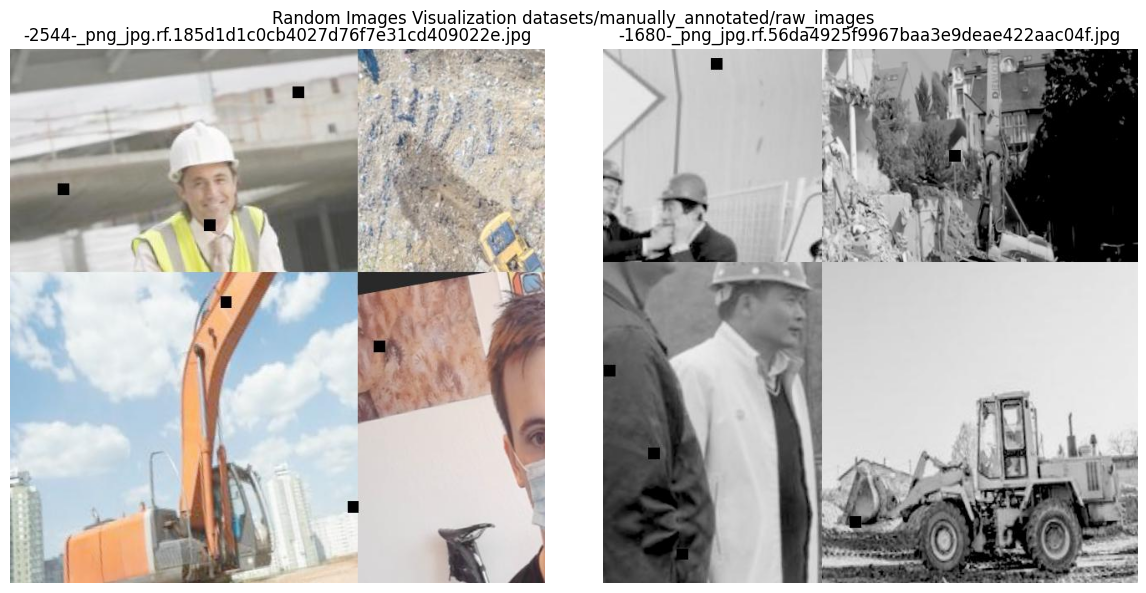

In [17]:
# define function to visualize random images
def visualize_images(images_dir, num_images=5):
    random.seed(42)
    image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    selected_files = random.sample(image_files, min(num_images, len(image_files)))

    plt.figure(figsize=(12, 6))
    for i, image_file in enumerate(selected_files):
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(image_file)
    plt.suptitle(f"Random Images Visualization {images_dir}")
    plt.tight_layout()
    plt.show()
    
visualize_images(manual_source_images_dir, num_images=2)

### Custom images dataset

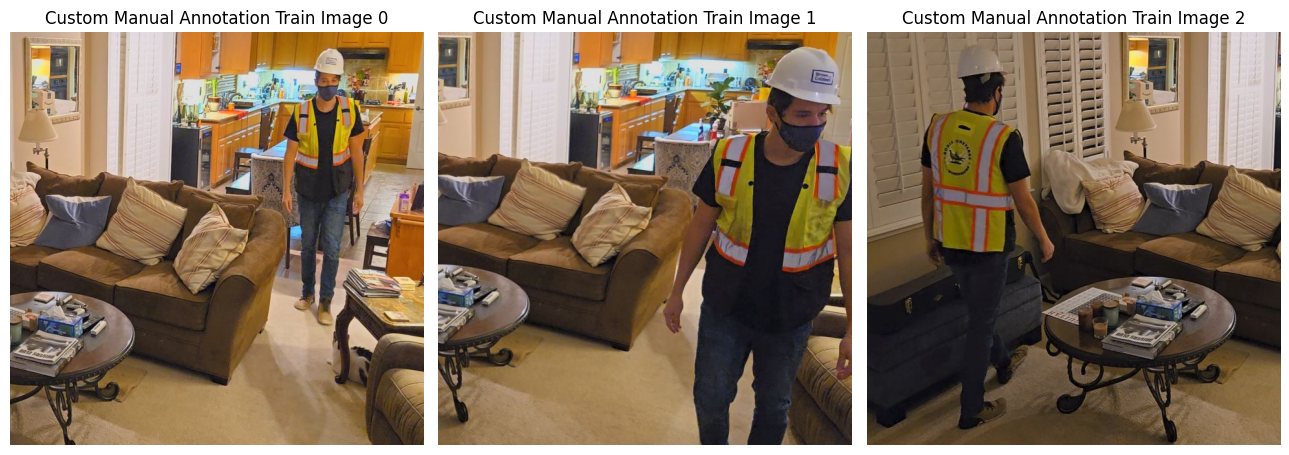

In [18]:
# Get the paths to the first three custom images
image_paths = glob.glob(f"{manual_source_images_dir}/scene*.jpg")[:3]

# Check if there are enough images
if len(image_paths) < 3:
    print("Not enough images found!")
else:
    # Create a subplot with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(13, 7))  # Width, height

    for i, ax in enumerate(axes):
        # Load and display each image
        image = mpimg.imread(image_paths[i])
        ax.imshow(image)
        ax.axis('off')  # Hide axes
        ax.set_title(f"Custom Manual Annotation Train Image {i}")

    plt.tight_layout()
    plt.show()

### Google images dataset

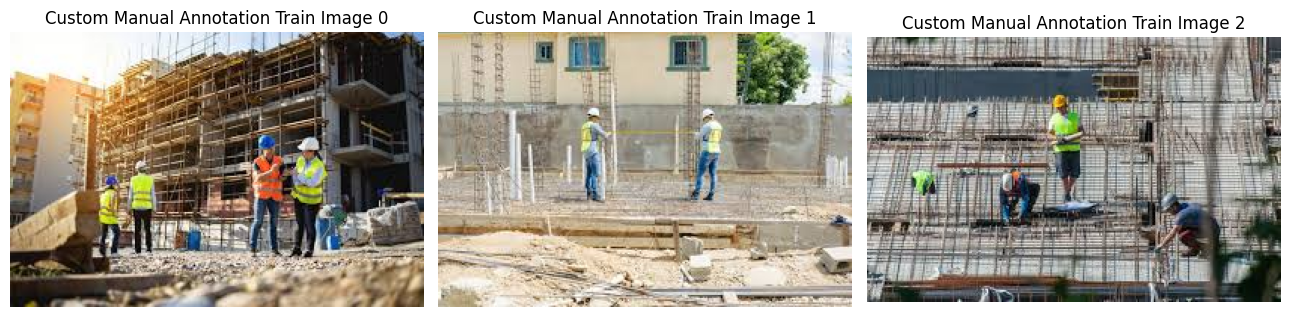

In [19]:
# Get the paths to the first three custom images
image_paths = glob.glob(f"{raw_images_dir}/images*.jpeg")[:3]

# Check if there are enough images
if len(image_paths) < 3:
    print("Not enough images found!")
else:
    # Create a subplot with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(13, 7))  # Width, height

    for i, ax in enumerate(axes):
        # Load and display each image
        image = mpimg.imread(image_paths[i])
        ax.imshow(image)
        ax.axis('off')  # Hide axes
        ax.set_title(f"Custom Manual Annotation Train Image {i}")

    plt.tight_layout()
    plt.show()

### Image Properties

In [20]:
# Define function to analyze image dimensions, aspect ratio
def analyze_image_properties(images_dir):
    properties = {"filename": [], "width": [], "height": [], "aspect_ratio": []}

    for image_file in os.listdir(images_dir):
        if image_file.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(images_dir, image_file)
            image = cv2.imread(image_path)
            height, width = image.shape[:2]
            aspect_ratio = width / height
            properties["filename"].append(image_file)
            properties["width"].append(width)
            properties["height"].append(height)
            properties["aspect_ratio"].append(aspect_ratio)

    # Convert to pandas DataFrame for analysis
    df = pd.DataFrame(properties)
    return df
print("Image Properties Analysis Of Manually Labeled Images")
analyze_image_properties(manual_source_images_dir)

Image Properties Analysis Of Manually Labeled Images


filename  width  height  \
0    -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...    640     640   
1    -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...    640     640   
2    -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...    640     640   
3    -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...    640     640   
4    -1680-_png_jpg.rf.175b8e375a256e36cbe84985db1d...    640     640   
..                                                 ...    ...     ...   
154  youtube-619_jpg.rf.93749f0e33b2f7beb302dd2e176...    640     640   
155  youtube-697_jpg.rf.950b34f23e196850ec51a4add2e...    640     640   
156  youtube-727_jpg.rf.cb4c039b4ffea84835e67e2e3d2...    640     640   
157  youtube-804_jpg.rf.c4250b3c54e1cca8d5862297088...    640     640   
158  youtube-836_jpg.rf.df6fc9e569e7b6b850ecb75c377...    640     640   

     aspect_ratio  
0             1.0  
1             1.0  
2             1.0  
3             1.0  
4             1.0  
..            ...  
154           1.0  
155           1.0  
156           1.0  
157           1.0  
158           1.0  

[159 rows x 4 columns]

### Split manually annotated datasets to train and val

In [21]:
# Define function to split manually annotated dataset into train and valation sets
def split_manual_dataset(images_dir, labels_dir, split_ratio=0.8):
    image_files = [
        f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    random.shuffle(image_files)

    train_size = int(split_ratio * len(image_files))
    train_files = image_files[:train_size]
    val_files = image_files[train_size:]

    # Copy train files and corresponding labels
    for file in train_files:
        label_file = os.path.splitext(file)[0] + ".txt"  # Match label with image file
        image_src = os.path.join(images_dir, file)
        label_src = os.path.join(labels_dir, label_file)
        shutil.copy(image_src, os.path.join(manual_train_images_dir, file))
        shutil.copy(label_src, os.path.join(manual_train_labels_dir, label_file))

    # Copy val files and corresponding labels
    for file in val_files:
        label_file = os.path.splitext(file)[0] + ".txt"  # Match label with image file
        image_src = os.path.join(images_dir, file)
        label_src = os.path.join(labels_dir, label_file)
        shutil.copy(image_src, os.path.join(manual_val_images_dir, file))
        shutil.copy(label_src, os.path.join(manual_val_labels_dir, label_file))

    print("Manual dataset split completed. Images and labels copied to train and val directories.")

split_manual_dataset(manual_source_images_dir, manual_source_labels_dir)

Manual dataset split completed. Images and labels copied to train and val directories.


### <b><u>Train base model</b></u> with manually annotated datasets

In [22]:
# Train the generic model on manually labeled data
def train_model(manual_train_images, manual_val_images, epochs=50):

    # Train the model
    print("Training model on manually labeled dataset...")
    model = YOLO("../../models/yolov8m.pt")
    model.train(
        data=manual_yaml_path,
        epochs=50, # Iterations
        imgsz=640, # Image size
        batch=16, # Batch size
        seed=88, # Train Repeatability
        lr0=1e-4,  # Learning rate 
        optimizer="auto", # Automatic speed, stability optimization
        patience=10 # Num of epochs to discontinue unimproved train
    )
    print("Model training completed.")
    return model

# Train the model on the manual dataset
trained_model = train_model(manual_train_images_dir, manual_val_images_dir)

Training model on manually labeled dataset...
Ultralytics 8.3.32  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) i9-14900KF)
engine\trainer: task=detect, mode=train, model=../../models/yolov8m.pt, data=C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\manual_data.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retin

train: Scanning C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\m

train: New cache created: C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\manually_annotated\labels\train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\man

val: New cache created: C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\manually_annotated\labels\val.cache


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G       1.64       3.57      1.751        197        640: 100%|██████████| 8/8 [01:05<00:00,  8.18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<0

                   all         32        320      0.336      0.157      0.182     0.0996



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.419      2.513      1.611        230        640: 100%|██████████| 8/8 [01:03<00:00,  7.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:08<0

                   all         32        320      0.415      0.352      0.303      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.242      1.891      1.435        201        640: 100%|██████████| 8/8 [01:04<00:00,  8.07
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         32        320      0.359      0.366      0.334      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.215      1.642      1.406        247        640: 100%|██████████| 8/8 [01:04<00:00,  8.00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:07<0

                   all         32        320      0.569      0.347      0.369      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.166        1.6      1.378        192        640: 100%|██████████| 8/8 [01:03<00:00,  7.88
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.628      0.378      0.439      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.176      1.528      1.392        235        640: 100%|██████████| 8/8 [01:03<00:00,  7.99
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.454       0.47      0.409      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G       1.16      1.466      1.351        202        640: 100%|██████████| 8/8 [01:03<00:00,  8.00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.537      0.438      0.432      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.166      1.419      1.356        213        640: 100%|██████████| 8/8 [01:04<00:00,  8.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.604      0.445      0.455      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.134      1.251      1.326        275        640: 100%|██████████| 8/8 [01:04<00:00,  8.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320       0.44      0.446      0.405      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.133      1.272      1.329        193        640: 100%|██████████| 8/8 [01:05<00:00,  8.17
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.578      0.397      0.409      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.184      1.289      1.317        214        640: 100%|██████████| 8/8 [01:05<00:00,  8.13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.685      0.402      0.453      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.118      1.228       1.31        200        640: 100%|██████████| 8/8 [01:05<00:00,  8.19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.589      0.431      0.392      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G       1.12      1.294      1.336        165        640: 100%|██████████| 8/8 [01:04<00:00,  8.05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.525      0.354      0.383      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.106      1.177      1.286        182        640: 100%|██████████| 8/8 [01:06<00:00,  8.35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.727      0.431      0.477      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.051      1.096       1.27        255        640: 100%|██████████| 8/8 [01:06<00:00,  8.35
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.722      0.451      0.507      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.061      1.078      1.258        186        640: 100%|██████████| 8/8 [01:04<00:00,  8.04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.581       0.54      0.519      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.024      1.062      1.237        231        640: 100%|██████████| 8/8 [01:04<00:00,  8.02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320       0.78      0.468      0.512      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G     0.9876     0.9888      1.214        287        640: 100%|██████████| 8/8 [01:04<00:00,  8.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.613      0.537      0.558      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G     0.9946      1.036      1.233        219        640: 100%|██████████| 8/8 [01:04<00:00,  8.04
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.753      0.496      0.549      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G     0.9993      1.003      1.243        160        640: 100%|██████████| 8/8 [01:05<00:00,  8.13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.719      0.478      0.549      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G     0.9559     0.9003      1.197        219        640: 100%|██████████| 8/8 [01:05<00:00,  8.15
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.805      0.516      0.562      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G     0.9387     0.8932        1.2        190        640: 100%|██████████| 8/8 [01:04<00:00,  8.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.807      0.481      0.557      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G     0.9276      0.867      1.179        244        640: 100%|██████████| 8/8 [01:06<00:00,  8.31
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.571      0.512      0.549      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G     0.8994     0.8465      1.158        250        640: 100%|██████████| 8/8 [01:05<00:00,  8.13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.653      0.482      0.545      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G     0.9188     0.8312      1.169        227        640: 100%|██████████| 8/8 [01:05<00:00,  8.22
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.647      0.531      0.534      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.9011     0.8285      1.151        148        640: 100%|██████████| 8/8 [01:03<00:00,  7.95
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.684      0.518      0.569      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.8763     0.8197      1.143        294        640: 100%|██████████| 8/8 [01:03<00:00,  7.97
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.719      0.547      0.601      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G     0.8842      0.781       1.13        217        640: 100%|██████████| 8/8 [01:03<00:00,  7.95
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.694      0.549      0.589      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.8276      0.754       1.12        236        640: 100%|██████████| 8/8 [01:06<00:00,  8.36
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.758      0.515      0.594      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G     0.8566     0.7617      1.125        230        640: 100%|██████████| 8/8 [01:06<00:00,  8.27
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.729      0.558       0.61       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.8267      0.712      1.124        181        640: 100%|██████████| 8/8 [01:04<00:00,  8.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.713      0.539      0.602      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.8205     0.7531      1.121        236        640: 100%|██████████| 8/8 [01:05<00:00,  8.20
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.722      0.521      0.576      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.8054     0.6808      1.099        269        640: 100%|██████████| 8/8 [01:04<00:00,  8.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.734      0.553      0.607      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      0.784     0.6921      1.087        255        640: 100%|██████████| 8/8 [01:04<00:00,  8.02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.736      0.535      0.605      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G     0.7651     0.6555       1.08        242        640: 100%|██████████| 8/8 [01:07<00:00,  8.38
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.706      0.593      0.629      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.7756     0.7225      1.102        235        640: 100%|██████████| 8/8 [01:07<00:00,  8.39
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.765      0.578      0.639      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.7636     0.6445      1.064        213        640: 100%|██████████| 8/8 [01:04<00:00,  8.10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.799      0.596      0.663      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      0.719     0.6225       1.07        196        640: 100%|██████████| 8/8 [01:07<00:00,  8.42
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.787       0.57      0.656      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G     0.7363     0.6476      1.071        277        640: 100%|██████████| 8/8 [01:05<00:00,  8.18
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.841      0.556      0.652      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.7321     0.6426      1.068        196        640: 100%|██████████| 8/8 [01:05<00:00,  8.13
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.847      0.574      0.663      0.394


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      0.719     0.5725       1.07        153        640: 100%|██████████| 8/8 [01:04<00:00,  8.03
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.898      0.552      0.672      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.6659     0.5407      1.026         95        640: 100%|██████████| 8/8 [01:03<00:00,  7.93
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.866      0.589      0.682      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      0.691       0.56      1.054        134        640: 100%|██████████| 8/8 [01:04<00:00,  8.02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.911      0.583      0.684      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.6427     0.5381      1.028        122        640: 100%|██████████| 8/8 [01:04<00:00,  8.02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.882      0.593      0.693      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G     0.6143     0.4967     0.9852        115        640: 100%|██████████| 8/8 [01:05<00:00,  8.15
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.877      0.599      0.711      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.6119     0.4926      1.005         98        640: 100%|██████████| 8/8 [01:05<00:00,  8.19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.821      0.634      0.715      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G     0.6384      0.486      1.014        110        640: 100%|██████████| 8/8 [01:04<00:00,  8.02
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320       0.76      0.697      0.728      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.5822     0.4598     0.9919        126        640: 100%|██████████| 8/8 [01:04<00:00,  8.11
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.793      0.654      0.721      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G     0.5866     0.4564     0.9687        127        640: 100%|██████████| 8/8 [01:04<00:00,  8.00
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.807      0.679      0.728      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.5758     0.4311     0.9726        134        640: 100%|██████████| 8/8 [01:04<00:00,  8.01
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<0

                   all         32        320      0.806      0.678       0.73      0.427



50 epochs completed in 1.002 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 52.0MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.32  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) i9-14900KF)
Model summary (fused): 218 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0


                   all         32        320      0.798      0.679      0.729      0.427
               Hardhat         22         41      0.969       0.77      0.866      0.634
                  Mask         11         13      0.805      0.846      0.889      0.571
            NO-Hardhat         14         16      0.905      0.599      0.669      0.263
               NO-Mask         18         34      0.668      0.618      0.672      0.309
        NO-Safety Vest         18         40       0.71      0.551      0.622      0.341
                Person         31         83      0.777      0.687      0.734        0.5
           Safety Cone          4         20      0.963       0.55      0.648      0.324
           Safety Vest         16         21      0.853       0.81      0.914      0.511
             Machinery         17         48      0.594      0.646       0.64      0.386
               Vehicle          3          4      0.739      0.717      0.642      0.429
Speed: 1.0ms preproce

### Automatically annotate datasets with base model

In [26]:
# load the pre-trained model to auto annotated the raw_images
model_path = "runs/detect/train/weights/best.pt"  # Path to your trained YOLO model
def auto_annotate_images(model_path, raw_images_dir, output_images_dir, output_labels_dir, confidence_threshold=0.5):
    
    """
    Automatically annotate images using a pre-trained YOLO model.

    Args:
    - model_path (str): Path to the trained YOLO model.
    - raw_images_dir (str): Path to the directory containing raw images.
    - output_images_dir (str): Path to save annotated images.
    - output_labels_dir (str): Path to save annotation labels in YOLO format.
    - confidence_threshold (float): Minimum confidence score to include a detection.
    """
    total_images = len([image_file for image_file in os.listdir(raw_images_dir) if image_file.lower().endswith(('.jpg', '.jpeg', '.png'))])
    # load the pre-trained model
    model = YOLO(model_path)

    # Create output directories if they don't exist
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)
        
    for i, image_file in enumerate(os.listdir(raw_images_dir)):
        if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(raw_images_dir, image_file)
            results = model(image_path, verbose=False)  # Perform inference, silence output for each image

            # Save the original image to the output directory
            output_image_path = os.path.join(output_images_dir, image_file)
            cv2.imwrite(output_image_path, cv2.imread(image_path))

            # Prepare the YOLO format label file
            label_file = os.path.splitext(image_file)[0] + ".txt"
            output_label_path = os.path.join(output_labels_dir, label_file)

            with open(output_label_path, "w") as f:
                for result in results[0].boxes:
                    box = result.xywhn[0].cpu().numpy()  # Normalized x_center, y_center, width, height
                    class_id = int(result.cls[0].cpu().numpy())
                    confidence = float(result.conf[0].cpu().numpy())

                    # Filter by confidence threshold
                    if confidence >= confidence_threshold:
                        f.write(f"{class_id} {box[0]:.3f} {box[1]:.3f} {box[2]:.3f} {box[3]:.3f}\n")

            # Print the current progress (overwrite previous line)
            print(f"Annotating image {i+1} of {total_images}...", end='\r')
    
    print(f"Auto-annotation completed.\n' Annotated images and labels saved in {output_images_dir} and {output_labels_dir}.")
        
auto_annotate_images(model_path, raw_images_dir, auto_annotated_images_dir, auto_annotated_labels_dir)

Auto-annotation completed. Annotated images and labels saved in datasets/auto_annotated/images and datasets/auto_annotated/labels.


### Visualize auto-annotated datasets for model accuracy

In [39]:
# visualize auto-annotation to ensure correct bounding
def visualize_annotations(image_dir, label_dir, ppe_classes, num_images=5):
    """
    Visualize YOLO-format annotations on images.

    Args:
    - image_dir (str): Path to the directory containing annotated images.
    - label_dir (str): Path to the directory containing YOLO-format label files.
    - ppe_classes (list): List of class names corresponding to class IDs.
    - num_images (int): Number of images to visualize.
    """

    num_classes = len(ppe_classes)
    colors = [
        (random.randint(0, 255),
         random.randint(0, 255),
         random.randint(0, 255)) for _ in range(num_classes)
    ]

    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Select a subset of images to visualize
    image_files = random.sample(image_files, min(num_images, len(image_files)))

    for image_file in image_files:
        # Read the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image: {image_file}")
            continue

        # Convert the image to RGB for visualization
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Read the corresponding label file
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(label_dir, label_file)
        if not os.path.exists(label_path):
            print(f"Label file not found for image: {image_file}")
            continue

        with open(label_path, "r") as f:
            labels = f.readlines()

        # Overlay bounding boxes and class names on the image
        for label in labels:
            label_data = label.strip().split()
            class_id = int(label_data[0])
            x_center, y_center, width, height = map(float, label_data[1:])

            # Convert normalized YOLO coordinates to image pixel coordinates
            img_height, img_width, _ = image.shape
            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height

            x1 = int(x_center - width / 2)
            y1 = int(y_center - height / 2)
            x2 = int(x_center + width / 2)
            y2 = int(y_center + height / 2)

            # Draw the bounding box
            #color = (255, 0, 0)  # Blue color for bounding box
            color = colors[class_id]
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Put the class name text
            label_text = f"{ppe_classes[class_id]}"
            cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Display the image
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Annotations for {image_file}")
        plt.show()

visualize_annotations(auto_annotated_images_dir, auto_annotated_labels_dir, ppe_classes, num_images=2)

### Combine manual and auto annotated datasets

In [40]:
# Function to combine datasets (manual + auto-annotated)
# combined directory path

combined_images_dir = os.path.join(dataset_base_dir, "images")
combined_labels_dir = os.path.join(dataset_base_dir, "labels")

# check if path exist otherwise create it
os.makedirs(combined_images_dir, exist_ok=True)
os.makedirs(combined_labels_dir, exist_ok=True)


def copy_files(src_images_dir, src_labels_dir):
    for file in os.listdir(src_images_dir):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Copy image file
            src_image_path = os.path.join(src_images_dir, file)
            dest_image_path = os.path.join(combined_images_dir, file)
            shutil.copy(src_image_path, dest_image_path)

            # Copy corresponding label file
            label_file = os.path.splitext(file)[0] + ".txt"
            src_label_path = os.path.join(src_labels_dir, label_file)
            dest_label_path = os.path.join(combined_labels_dir, label_file)
            shutil.copy(src_label_path, dest_label_path)
            
# copy manually annotated images data
print("Copying manually annotated training data...")
copy_files(manual_train_images_dir, manual_train_labels_dir)

# copy manually annotated validation data
print("Copying manually annotated validation data...")
copy_files(manual_val_images_dir, manual_val_labels_dir)

# Copy auto-annotated data
print("Copying auto-annotated data...")
copy_files(auto_annotated_images_dir, auto_annotated_labels_dir)

print("Dataset combination completed.")
print(f"Combined images stored in: {combined_images_dir}")
print(f"Combined labels stored in: {combined_labels_dir}")

Copying manually annotated training data...
Copying manually annotated validation data...
Copying auto-annotated data...
Dataset combination completed.
Combined images stored in: datasets/images
Combined labels stored in: datasets/labels


### Split combined images and labels to train, test and val

In [41]:
# extract the combined image files for random split
# split directory for detection
train_images_dir = os.path.join(dataset_base_dir, "images/train")
train_labels_dir = os.path.join(dataset_base_dir, "labels/train")

test_images_dir = os.path.join(dataset_base_dir, "images/test")
test_labels_dir = os.path.join(dataset_base_dir, "labels/test")

val_images_dir = os.path.join(dataset_base_dir, "images/val")
val_labels_dir = os.path.join(dataset_base_dir, "labels/val")

# create dataset directories for detection & prediction
for dir_path in [
    train_images_dir,
    train_labels_dir,
    test_images_dir,
    test_labels_dir,
    val_images_dir,
    val_labels_dir
]:
    os.makedirs(dir_path, exist_ok=True)

image_files = [f for f in os.listdir(combined_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)

# Create DataFrame with file paths and dataset split assignments
df = pd.DataFrame({"filename": image_files})
# dynamically split dataset into train, valid, and test
# split sizes
train_size = int(0.7 * len(df))  # 70% for training
val_size = int(0.2 * len(df))  # 20% for validation
test_size = len(df) - train_size - val_size  # remaining 10% for testing

# split labels
train_labels = ["train"] * train_size
val_labels = ["val"] * val_size
test_labels = ["test"] * test_size

# combine and assign to DataFrame
df["split"] = train_labels + val_labels + test_labels

# Function to move files into corresponding split directories
def move_files(df, src_images_dir, src_labels_dir, dest_images_dir, dest_labels_dir):
    for _, row in df.iterrows():  # iterate over a DataFrame row by row
        filename = row["filename"]
        split = row["split"]
        image_path = os.path.join(src_images_dir, filename)
        label_path = os.path.join(src_labels_dir, os.path.splitext(filename)[0] + ".txt")

        dest_image_dir = dest_images_dir[split]
        dest_label_dir = dest_labels_dir[split]

        # move image
        shutil.move(image_path, os.path.join(dest_image_dir, filename))

        # move label 
        shutil.move(label_path, os.path.join(dest_label_dir, os.path.splitext(filename)[0] + ".txt"))
        

# map split directories for images and labels
dest_images_dir = {"train": train_images_dir, "val": val_images_dir, "test": test_images_dir}
dest_labels_dir = {"train": train_labels_dir, "val": val_labels_dir, "test": test_labels_dir}

# call move fuxn
move_files(df, combined_images_dir, combined_labels_dir, dest_images_dir, dest_labels_dir)

print("Dataset split completed.")
print(f"Training images: {len(os.listdir(train_images_dir))}, Labels: {len(os.listdir(train_labels_dir))}")
print(f"Validation images: {len(os.listdir(val_images_dir))}, Labels: {len(os.listdir(val_labels_dir))}")
print(f"Testing images: {len(os.listdir(test_images_dir))}, Labels: {len(os.listdir(test_labels_dir))}")

Dataset split completed.
Training images: 2043, Labels: 2043
Validation images: 584, Labels: 584
Testing images: 293, Labels: 293


### <b><u>Train the final model </b></u>with the combined datasets
#### (NOTE: update model_path for the base model created)

In [33]:
input_name = input('Please enter run folder description:')
# load pre-trained YOLO base model
model_path = "runs/detect/train/weights/best.pt"
model = YOLO(model_path)
# Train the model
print("Training the final model...")
model.train(
    data=final_yaml_path,
    epochs=30, # Iterations
    imgsz=640, # Image size
    batch=20, # Batch size
    lr0=1e-3, # Learning rate
    patience=10, # Num of epochs to discontinue unimproved train
    amp=True, # Reduce memore, increase speed
    plots = True, # produce plots
    seed=88, # Train repeatability
    name = input_name, # Run folder name
)
print("Model training completed.")

Training the final model...
New https://pypi.org/project/ultralytics/8.3.38 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.33 🚀 Python-3.11.9 torch-2.5.1 CPU (Apple M3 Pro)
engine/trainer: task=detect, mode=train, model=runs/detect/train/weights/best.pt, data=../models/datasets.yaml, epochs=30, time=None, patience=10, batch=20, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embe

train: Scanning /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/datasets/labels/train.cache... 2656 images, 60 backgrounds, 0 corrupt: 100%|██████████| 2656/2656 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /Users/fatimatatanda/Library/CloudStorage/OneDrive-Personal/Desktop/USD/Projects/aai-501-final-project/datasets/labels/val.cache... 175 images, 1 backgrounds, 0 corrupt: 100%|██████████| 175/175 [00:00<?, ?it/s]

Plotting labels to runs/detect/train4/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.00046875), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train4
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G     0.8476      1.012      1.197        221        640: 100%|██████████| 133/133 [1:17:13<00:00, 34.84s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.88s/it]

                   all        175       1409      0.751      0.762      0.825       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G     0.9253      1.116      1.239        243        640: 100%|██████████| 133/133 [45:30<00:00, 20.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.86s/it]

                   all        175       1409      0.693      0.655      0.692      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G     0.9616      1.176       1.26        143        640: 100%|██████████| 133/133 [45:34<00:00, 20.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.82s/it]

                   all        175       1409      0.631      0.664      0.675      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G     0.9604      1.157      1.255        200        640: 100%|██████████| 133/133 [45:32<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.85s/it]

                   all        175       1409      0.714      0.705      0.759      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G     0.9396       1.12      1.242        224        640: 100%|██████████| 133/133 [45:31<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.85s/it]

                   all        175       1409      0.728      0.733      0.769      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G     0.9102      1.081      1.222        156        640: 100%|██████████| 133/133 [45:32<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.81s/it]

                   all        175       1409      0.722      0.759      0.806      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G     0.8813       1.02      1.205        196        640: 100%|██████████| 133/133 [45:34<00:00, 20.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.88s/it]

                   all        175       1409      0.759      0.745      0.797      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G     0.8526     0.9793      1.189        155        640: 100%|██████████| 133/133 [45:31<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.87s/it]

                   all        175       1409      0.771      0.733       0.79       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G     0.8388     0.9419      1.183        200        640: 100%|██████████| 133/133 [45:30<00:00, 20.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.84s/it]

                   all        175       1409      0.747      0.773      0.815      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G     0.8247     0.9245       1.17        225        640: 100%|██████████| 133/133 [45:30<00:00, 20.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.86s/it]

                   all        175       1409      0.756      0.786      0.819      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G     0.8024     0.8924       1.16        198        640: 100%|██████████| 133/133 [45:32<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.88s/it]

                   all        175       1409        0.8      0.787      0.847      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      0.794     0.8722      1.146        180        640: 100%|██████████| 133/133 [45:33<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.79s/it]

                   all        175       1409       0.77       0.79      0.834      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G     0.7835      0.848      1.139        303        640: 100%|██████████| 133/133 [45:33<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.84s/it]

                   all        175       1409      0.817      0.788      0.852      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G     0.7612     0.8223      1.127        298        640: 100%|██████████| 133/133 [45:31<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.85s/it]

                   all        175       1409      0.804      0.789      0.858      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G     0.7546      0.806      1.122        160        640: 100%|██████████| 133/133 [45:32<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.86s/it]

                   all        175       1409      0.791      0.803      0.851       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G     0.7356     0.7834      1.114        171        640: 100%|██████████| 133/133 [45:33<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.79s/it]

                   all        175       1409      0.811      0.819      0.866      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G     0.7242     0.7642        1.1        252        640: 100%|██████████| 133/133 [45:32<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.78s/it]

                   all        175       1409      0.805      0.837      0.868      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G     0.7128     0.7491      1.101        305        640: 100%|██████████| 133/133 [45:31<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.88s/it]

                   all        175       1409      0.813      0.822      0.867      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G     0.7043     0.7331      1.094        190        640: 100%|██████████| 133/133 [45:31<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.85s/it]

                   all        175       1409      0.821      0.818      0.868      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G     0.6807     0.7081      1.079        157        640: 100%|██████████| 133/133 [45:32<00:00, 20.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.82s/it]

                   all        175       1409      0.802      0.845      0.883      0.685


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30         0G     0.6734     0.6241      1.082        100        640: 100%|██████████| 133/133 [45:28<00:00, 20.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.84s/it]

                   all        175       1409      0.814      0.834      0.868      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30         0G     0.6487     0.5883      1.067         99        640: 100%|██████████| 133/133 [45:28<00:00, 20.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.87s/it]

                   all        175       1409      0.798      0.861      0.886      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30         0G     0.6351     0.5559      1.058        119        640: 100%|██████████| 133/133 [45:36<00:00, 20.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.81s/it]

                   all        175       1409      0.816      0.823      0.883      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30         0G     0.6246     0.5412      1.052        103        640: 100%|██████████| 133/133 [45:31<00:00, 20.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.87s/it]

                   all        175       1409      0.816      0.826      0.882      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30         0G      0.601     0.5232      1.035        117        640: 100%|██████████| 133/133 [47:50<00:00, 21.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.82s/it]

                   all        175       1409      0.824      0.821      0.876      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30         0G     0.5886     0.5004      1.033         85        640: 100%|██████████| 133/133 [45:27<00:00, 20.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.73s/it]

                   all        175       1409      0.825       0.85      0.884      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30         0G     0.5779     0.4901      1.025        167        640: 100%|██████████| 133/133 [45:27<00:00, 20.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.86s/it]

                   all        175       1409      0.801       0.85      0.887      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30         0G     0.5602     0.4692      1.011         96        640: 100%|██████████| 133/133 [45:36<00:00, 20.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.84s/it]

                   all        175       1409       0.83      0.832      0.883      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30         0G     0.5486     0.4525      1.005         77        640: 100%|██████████| 133/133 [45:37<00:00, 20.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.90s/it]

                   all        175       1409      0.804      0.868       0.89      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30         0G     0.5328      0.435     0.9977        136        640: 100%|██████████| 133/133 [45:38<00:00, 20.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:09<00:00, 13.88s/it]

                   all        175       1409      0.844      0.843       0.89      0.714



30 epochs completed in 23.917 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 52.0MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.33 🚀 Python-3.11.9 torch-2.5.1 CPU (Apple M3 Pro)
Model summary (fused): 218 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.37s/it]


                   all        175       1409      0.805      0.868       0.89      0.715
               Hardhat         50        114      0.863      0.956      0.972       0.83
                  Mask         60         74      0.829      0.946      0.929      0.782
            NO-Hardhat         63         88      0.833      0.875      0.915      0.737
               NO-Mask         55        100      0.772       0.83      0.841       0.56
        NO-Safety Vest         80        128      0.722       0.73      0.808       0.62
                Person        150        412      0.885       0.92      0.956      0.825
           Safety Cone         29         99       0.89       0.96      0.949      0.744
           Safety Vest         61        114      0.785      0.842       0.89      0.709
             Machinery        123        247      0.778      0.822      0.854      0.739
               Vehicle         23         33      0.688      0.801      0.783      0.601
Speed: 0.5ms preproce

### Evalutate train results

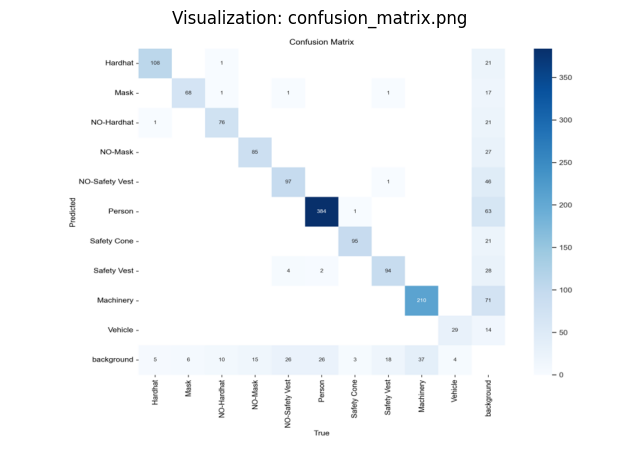

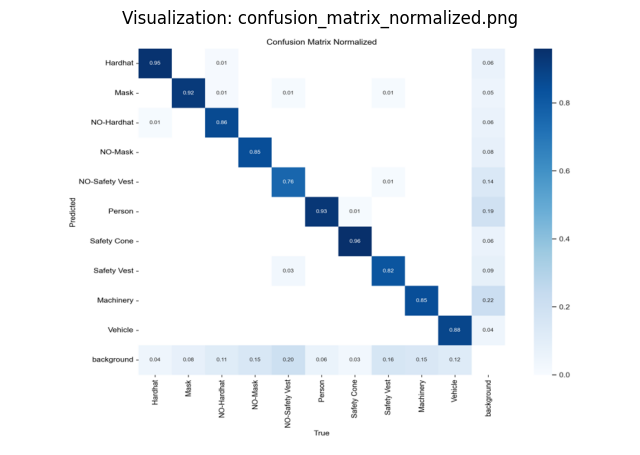

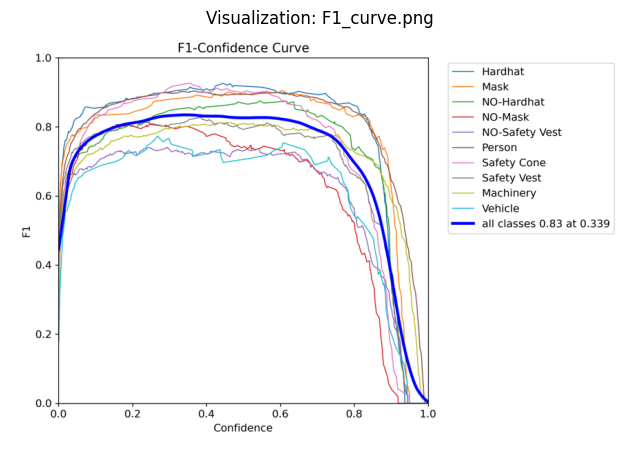

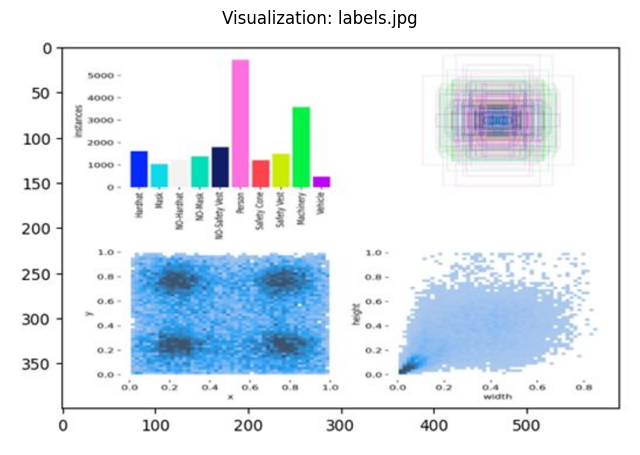

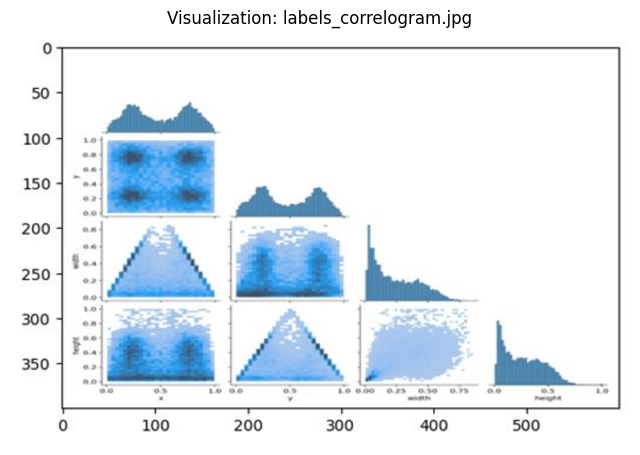

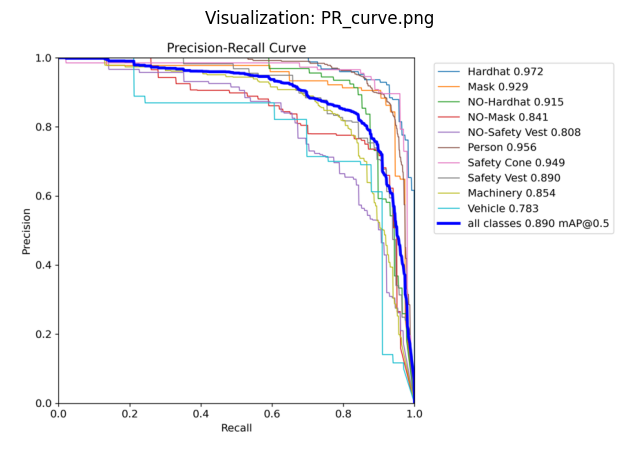

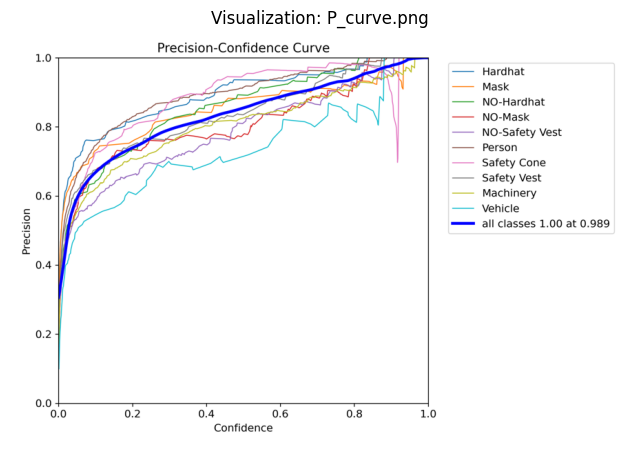

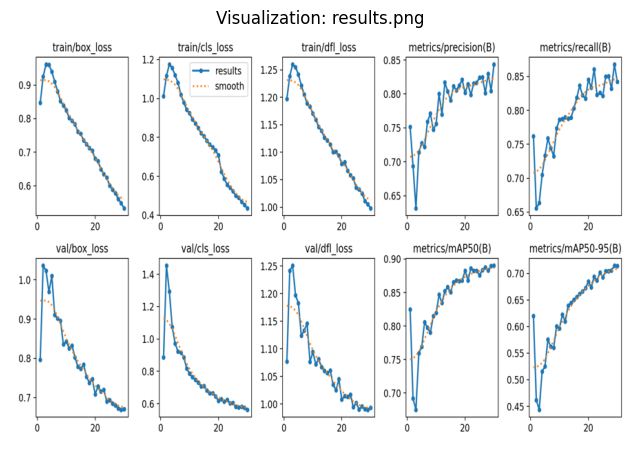

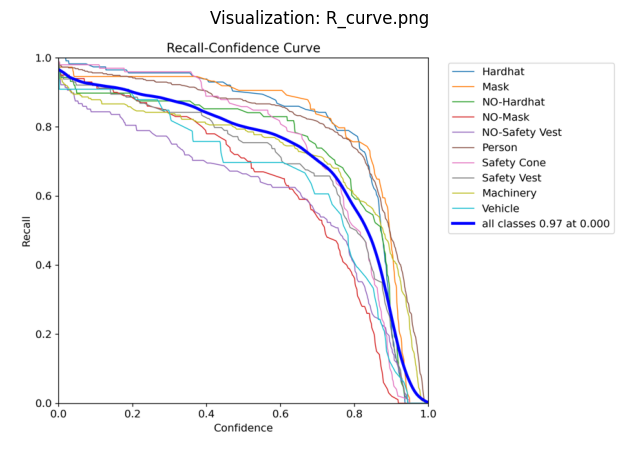

In [52]:
run_path = "runs/detect/train4"
# loop through images, do not include images for val and train
img_files = [
    f for f in os.listdir(run_path) 
    if f.endswith((".png", ".jpg")) and not f.startswith(("train", "val"))
]

# Loop through each image file and display it
for img_file in img_files:
    file_path = os.path.join(run_path, img_file)
    image = Image.open(file_path).resize((900, 600)) # Width, height
    # Display the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title(f"Visualization: {img_file}")
    plt.show()

### Visualize prediction on test sets


image 1/1 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\images\test\youtube-497_jpg.rf.e0f0250ef7939eb4813e9b2f57b1a5ff.jpg: 640x640 1 Mask, 1 NO-Hardhat, 2 NO-Safety Vests, 2 Persons, 2 Machinerys, 267.9ms
Speed: 2.0ms preprocess, 267.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\images\test\IMG_3103_mp4-15_jpg.rf.d7e8a84fc7e9d53fe348320ea3af0e94.jpg: 640x640 2 Hardhats, 1 Mask, 2 NO-Hardhats, 3 NO-Masks, 1 NO-Safety Vest, 6 Persons, 1 Safety Cone, 1 Machinery, 253.6ms
Speed: 2.0ms preprocess, 253.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



image 1/1 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project\notebooks\hybrid_model_train\datasets\images\test\01261_jpg.rf.ee044d42291843f1358960c4d8c1d466.jpg: 640x640 4 Hardhats, 4 NO-Masks, 1 NO-Safety Vest, 4 Persons, 4 Safety Vests, 1 Vehicle, 235.2ms
Speed: 2.0ms preprocess, 235.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


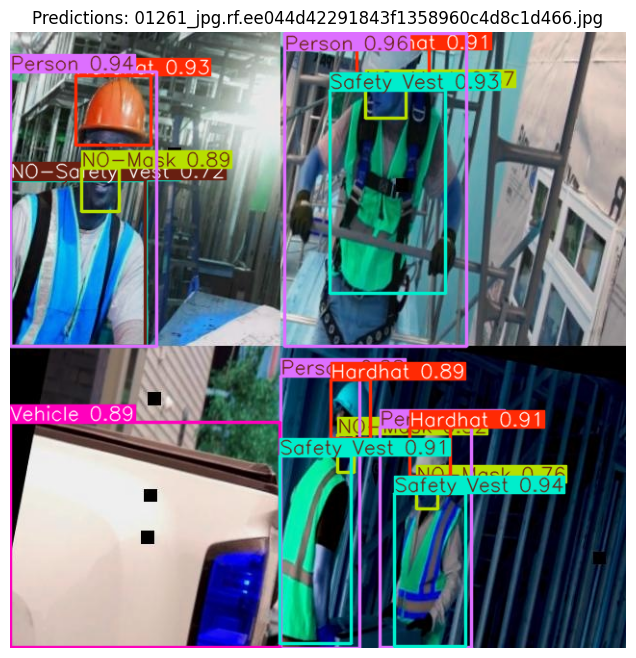

In [54]:
# load the final trained model
model = YOLO("runs/detect/train4/weights/best.pt")

# Path to test images
test_images_dir = "datasets/images/test"

# get list of test images
test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# run inference and display predictions
# shuffle the images randomly
random.shuffle(test_images)

# limit to a subset 
test_images_subset = test_images[:3]

# Run inference and display predictions for random images
for test_image in test_images_subset:
    image_path = os.path.join(test_images_dir, test_image)
    results = model.predict(source=image_path, save=False)  # Run inference

    # Display the image with predictions
    img = results[0].plot()  # YOLOv8's built-in method to plot predictions
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predictions: {test_image}")
    plt.show()

### Predict custom images

Results saved to runs\detect\predict


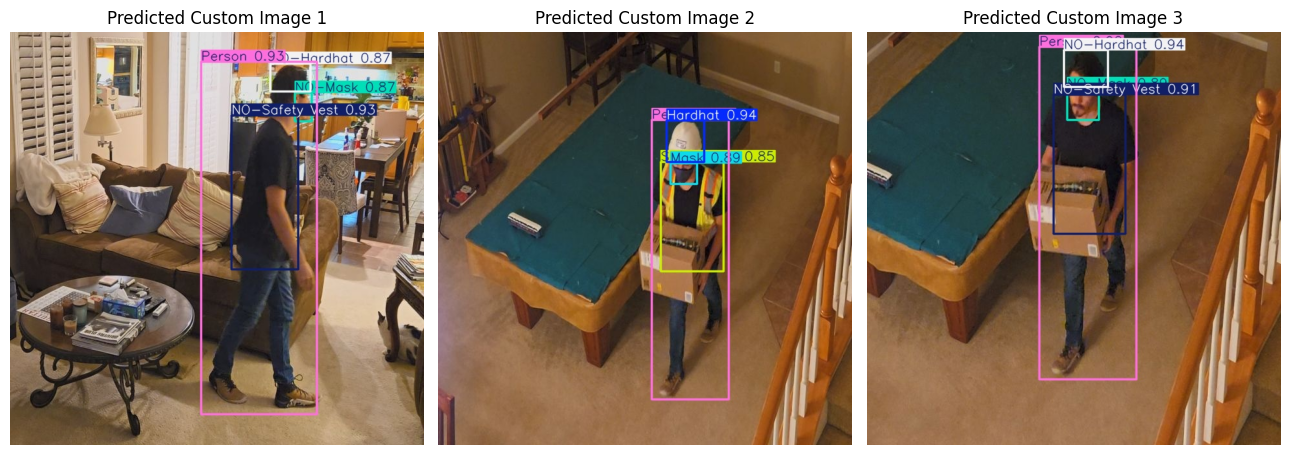

In [11]:
# Remove previous predictions
detect_path = "runs/detect/"
for folder in os.listdir(detect_path):
    folder_path = os.path.join(detect_path, folder)
    if os.path.isdir(folder_path) and folder.startswith("predict"):
        shutil.rmtree(folder_path, ignore_errors=True)

# Make predictions on "scene" images
model.predict(
    f"{test_images_dir}/scene*.jpg",
    save=True,
    conf=0.45,
    agnostic_nms=True,
    iou=0.8,
    verbose=False
)

# Visualize the first three predicted "scene" images
scene_predicted_paths = glob.glob("runs/detect/predict/scene*.jpg")[:3]

if len(scene_predicted_paths) < 3:
    print("Not enough predictions found!")
else:
    fig, axes = plt.subplots(1, 3, figsize=(13, 6))  # 1 row, 3 columns
    for i, ax in enumerate(axes):
        image = mpimg.imread(scene_predicted_paths[i])
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Predicted Custom Image {i + 1}")
    plt.tight_layout()
    plt.show()